# 线性模型

最简单最基本的模型，$\hat{y}=x*\omega+b $

定义损失函数为：$loss=\sum(\hat{y}-y)^2=\sum(x*\omega-y)^2$

对不同的$\omega$进行遍历，算出损失，找到最小的$\omega$

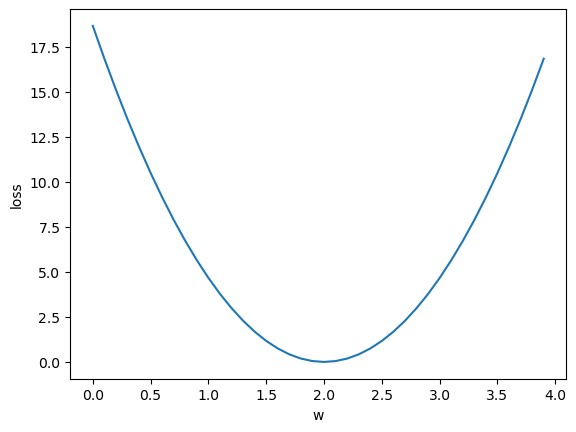

In [1]:
import numpy as np
import matplotlib.pylab as plt

x_data = [1.0, 2.0, 3.0]
y_data = [2.0, 4.0, 6.0]

def forward(x):
    return x * w
    
def loss(x, y):
    return (forward(x) - y) ** 2

w_list = []
mse_list = []
for w in np.arange(0.0, 4.0, 0.1):
    # print('w=', w)
    l_sum = 0.0
    for x_val, y_val in zip(x_data, y_data):
        y_pred_val = forward(x_val)
        loss_val = loss(x_val, y_val)
        l_sum += loss_val
        # print('\t', x_val, y_val, y_pred_val, loss_val)
    # print('MSE=', l_sum / len(x_data))
    w_list.append(w)
    mse_list.append(l_sum / 3)
    
plt.plot(w_list, mse_list)
plt.ylabel('loss')
plt.xlabel('w')
plt.show()

# 梯度下降算法

<img src = './Image/Pytorch深度学习实践/梯度下降.png' width = 400 align = right>
对于函数而言，梯度有$\nabla f = \frac{\partial f}{\partial x}$

对于当前的$\omega$，如果梯度大于0，说明误差在增大，否则误差在减小，故下一个取得的$\omega$为：

$\omega = \omega - \alpha * \frac{\partial f}{\partial x}$，其中$\alpha$参数称作学习率(学习率不能太大，否则会直接越过最低点)

梯度下降实际上是一种贪心算法，它得到的是局部区域的一个最优结果，如果损失函数不是一个“凸函数”，可能得不到最好的结果

现实中，太多的局部最优解其实很少见，更常见的是“鞍点”——梯度向量为0的点，在二维平面里，会出现无法继续迭代的现象，在三维即更高的空间里，可能出现从一个面看是最高点，而另一个面是最低点

<img src = './Image/Pytorch深度学习实践/鞍点.jpg' width = 400>

在cost函数中：
$$\frac{\partial cost(\omega)}{\partial \omega} = \frac{\partial}{\partial \omega} \frac{1}{N}\sum_{n=1}^N(x_n*\omega-y_n)^2 = \frac{1}{N}\sum_{n=1}^N2x_n(x_n*w-y_n)
$$
则
$$\omega = \omega - \alpha * \frac{\partial f}{\partial x} = \omega - \alpha * \frac{1}{N}\sum_{n=1}^N2x_n(x_n*w-y_n)$$

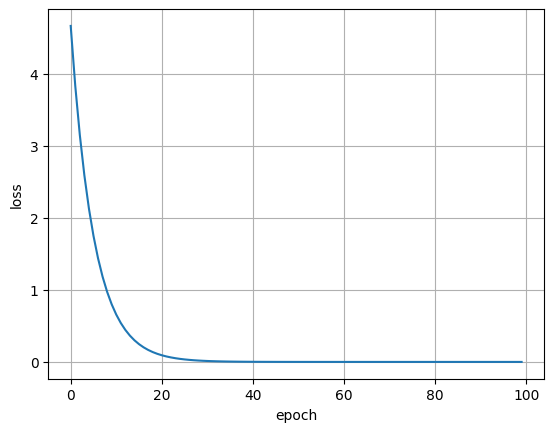

In [6]:
# 梯度下降算法
import matplotlib.pylab as plt

# prepare the training set
x_data = [1.0, 2.0, 3.0]
y_data = [2.0, 4.0, 6.0]

# initial guess of weight
w = 1.0


# define the model linear model y = w*x
def forward(x):
    return x * w


#define the cost function MSE
def cost(xs, ys):
    cost = 0
    for x, y in zip(xs, ys):
        y_pred = forward(x)
        cost += (y_pred - y)**2
    return cost / len(xs)


# define the gradient function  gd
def gradient(xs, ys):
    grad = 0
    for x, y in zip(xs, ys):
        grad += 2 * x * (x * w - y)
    return grad / len(xs)


epoch_list = []
cost_list = []
# print('predict (before training)', 4, forward(4))
for epoch in range(100):
    cost_val = cost(x_data, y_data)
    grad_val = gradient(x_data, y_data)
    w -= 0.01 * grad_val  # 0.01 learning rate
    # print('epoch:', epoch, 'w=', w, 'loss=', cost_val)
    epoch_list.append(epoch)
    cost_list.append(cost_val)

# print('predict (after training)', 4, forward(4))
plt.plot(epoch_list, cost_list)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

## 随机梯度下降算法
不采取整体的cost的梯度，而采取随机一个样本的loss的梯度，避免整体的梯度为0带来的鞍点导致无法更新$\omega$
+ 优点：避免了鞍点，性能好
+ 缺点：整体梯度下降可以采用并行计算最后汇总，而随机算法因为每次都会迭代更新$\omega$，如果要达到同样的训练此数，只能用循环 时间慢

解决方法：
+ 将原数据(batch)分组(mini_batch)，对每组用整体计算cost，然后随机挑选一组的cost

In [3]:
#随机梯度下降算法

# 反向传播与pytorch初步实现

反向传播的一个简要解析：[梯度反向传播简解](https://zhuanlan.zhihu.com/p/40378224)
<img src = './Image/Pytorch深度学习实践/反向传播.png' width = 300>
结合上图，我们的预测值$y$是一个关于输入的函数：$\hat{y}=f_\omega(\pmb{x})$，梯度下降算法通过对$loss = (\hat{y}-y)^2$求梯度，根据梯度修正参数$\omega$的值直到梯度/导数收敛为0，此时我们可以认为找到了最小的$loss$

问题的关键是如何对每个参数都求得对应的梯度，反向传播的思想为先正向算得中间量(forward过程)，然后利用链式法则，反向计算每个参数的梯度(Back Propagation过程)，前面的中间量可以带入到链式过程中简化运算；

Pytorch中以张量$Tensor(data,grad)$为基本类型(grad也为张量类型)，在构造前向图的时候，梯度信息会自动保留，当前向计算完毕时，在Tensor里的grad属性即会保留在这次运算中的梯度值

还是以$y=\omega x+b$为例

[1.0, 3.841600179672241, 7.315943717956543, 0.5465821623802185, 2.099749803543091, 3.9987640380859375, 0.2987521290779114, 1.1476863622665405, 2.1856532096862793, 0.16329261660575867, 0.6273048520088196, 1.1946394443511963, 0.08925279974937439, 0.34287363290786743, 0.6529689431190491, 0.048784039914608, 0.18740876019001007, 0.35690122842788696, 0.02666448801755905, 0.10243429243564606, 0.195076122879982, 0.014574333094060421, 0.055988773703575134, 0.10662525147199631, 0.007966067641973495, 0.030602457001805305, 0.0582793727517128, 0.004354109987616539, 0.016726721078157425, 0.03185431286692619, 0.002379868645220995, 0.00914248451590538, 0.017410902306437492, 0.001300786156207323, 0.004997097887098789, 0.009516451507806778, 0.000710982596501708, 0.0027312987949699163, 0.005201528314501047, 0.0003886088088620454, 0.0014928855234757066, 0.0028430151287466288, 0.0002124064340023324, 0.0008159824647009373, 0.0015539465239271522, 0.0001160974134108983, 0.00044599699322134256, 0.0008493617060

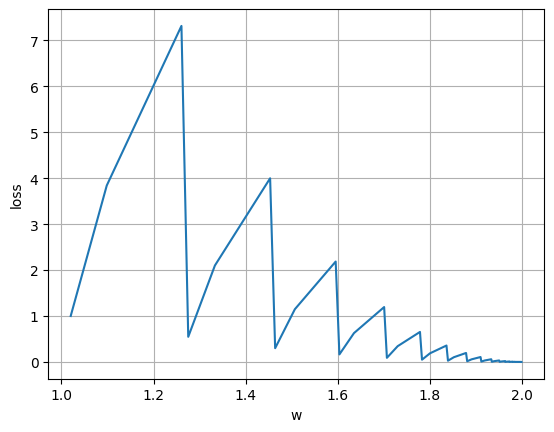

In [9]:
import torch
import matplotlib.pylab as plt

x_data = [1.0, 2.0, 3.0]
y_data = [2.0, 4.0, 6.0]

# w即为需要球梯度的张量
w = torch.Tensor([1.0])
w.requires_grad = True


def forword(x):
    # w为Tensor,最后的return会自动类型转换为Tensor
    return x * w

# 每次调用loss函数都会构造出一个计算图
def loss(x, y):
    y_pred = forword(x)
    return (y_pred - y) ** 2

l_list = []
w_list = []

for epoch in range(100):
    for x, y in zip(x_data, y_data):
        l = loss(x, y)
        l.backward()
        w.data = w.data - 0.01 * w.grad.data
        w.grad.data.zero_()
        l_list.append(l.item())
        w_list.append(w.item())
        
print(l_list)
plt.plot(w_list, l_list)
plt.ylabel('loss')
plt.xlabel('w')
plt.grid()
plt.show()

# pytorch运用